# Determine fluxes for Toya MDVs using the new LimitFlux2Core method

# Introduction

This notebook contains a description of the FluxModels module. This module contains classes for FBA, $^{13}$C MFA, and 2S-$^{13}$C MFA models, as well as for ELVA models. Each of this models has a corresponding results class: FBAResults, FVAResults, C13FVAResults, TSFVAResults, C13Results, TSResults, ELVAResults.

# Setup

First, we need to set the path and environment variable properly:

In [1]:
quantmodelDir = '/scratch/david.ando/published-jqmm/quantmodel'

This is the only place where the jQMM library path needs to be set.

In [2]:
%matplotlib inline

import sys, os
pythonPath = quantmodelDir+"/code/core"
if pythonPath not in sys.path:
    sys.path.append(pythonPath)
os.environ["QUANTMODELPATH"] = quantmodelDir

Then import the needed classes:

In [3]:
import FluxModels as FM
import enhancedLists, ReactionNetworks

And move to a scratch directory (to make things faster):

In [4]:
cd /scratch/david.ando/tests

/scratch/david.ando/tests


# Classes description

FluxModel represents the base class form which all other model classes are derived, but it is never used by itself. We will, hence, skip its description and demonstrate the classes that are actually used for flux calculations

## FBAModel, FBAresults and FVAresults

These classes are used for Flux Balance Analysis (FBA) and Flux Variability Analysis (FVA) calculations. For example: 

In [5]:
qmodeldir         = os.environ['QUANTMODELPATH']
basedir           = qmodeldir+'/data/tests/Toya2010/2S/'
testdir           = basedir + '2SpaperTest/'

FBAfileName = testdir+'XML/'+'EciJR904wt5hGrowthPartial.xml'    
FBAmodel    = FM.FBAModel(FBAfileName)

gets us an FBA model, and we can find fluxes by doing:

In [6]:
FBAresults  = FBAmodel.findFluxes()
fluxDictFBA = FBAresults.reactionNetwork.reactionList.getFluxDictionary()

In [7]:
print fluxDictFBA['PGI'].net

4.8848561646


In the same fashion, we can obtain the FVA results by doing:

In [8]:
FVAresults   = FBAmodel.FVA(['PDH','PGI','MDH'])
fluxDictFVA = FVAresults.reactionNetwork.reactionList.getReactionDictionary()

In [9]:
for name in ['PDH','PGI','MDH']:
    print name+": "+str(fluxDictFVA[name].flux.net)

PDH: [0:10.2006036871:18.6327817768]
PGI: [-6.98668484257:4.8848561646:11.5384750666]
MDH: [-8.28839116417:2.79597922572:29.2100898247]


One can use the **changeObjective** function to change the objective:

In [10]:
FBAmodel.changeObjective('BiomassEcoli',0)
FBAmodel.changeObjective('PDH',1)

In [11]:
FBAresults2 = FBAmodel.findFluxes()
fluxDictFBA2 = FBAresults2.reactionNetwork.reactionList.getFluxDictionary()

In [12]:
print fluxDictFBA['PDH'].net
print fluxDictFBA2['PDH'].net

10.2006036871
42.5


and the **printSuccess** method to print if the run was successful:

In [13]:
FBAresults.printSuccess(onlyFail=False)

lp successful


## C13Model, C13Results, C13FVAResults

These classes are used for $^{13}$C Metabolic Flux Analysis ($^{13}$C MFA) and $^{13}$C Flux variability Analysis ($^{13}$C FVA). 

For example, we can load the toy TCA cycle model:

In [14]:
qmodeldir         = os.environ['QUANTMODELPATH']    
dirDATA           = qmodeldir+'/data/tests/TCAtoy/' 

REACTIONSfilename   = dirDATA+'REACTIONStca.txt' 
FEEDfilename        = dirDATA+'FEEDtca.txt'
CEMSfilename        = dirDATA+'GCMStca.txt'
CEMSSTDfilename     = dirDATA+'GCMSerrtca.txt'
FLUXESFreefilename  = dirDATA+'FLUXtca.txt'

atomTransitions = enhancedLists.AtomTransitionList(REACTIONSfilename)
ReacNet = atomTransitions.getReactionNetwork('E. coli wt5h 13C MFA')

ReacNet.addLabeling(CEMSfilename,'LCMSLabelData',CEMSSTDfilename,minSTD=0.001)
ReacNet.addFeed(FEEDfilename)
ReacNet.loadFluxBounds(FLUXESFreefilename)

ReacNet.write('TCA.sbml') 

1

In [15]:
C13model = FM.C13Model('TCA.sbml')

And then calculate fluxes and use **findFluxesStds** to calculate fluxes and standard deviations through the monte carlo approach:

In [16]:
%%time
results    = C13model.findFluxesStds(Nrep=10, procString='proc', erase=True)

CPU times: user 1.05 s, sys: 2.26 s, total: 3.3 s
Wall time: 7.53 s


**plotExpvsCompLabelFragment** and **plotExpvsCompLabelXvsY** provide alternative ways to see the fits: 

/usr/local/share/jupyteruser/.virtualenvs/jbeipython2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


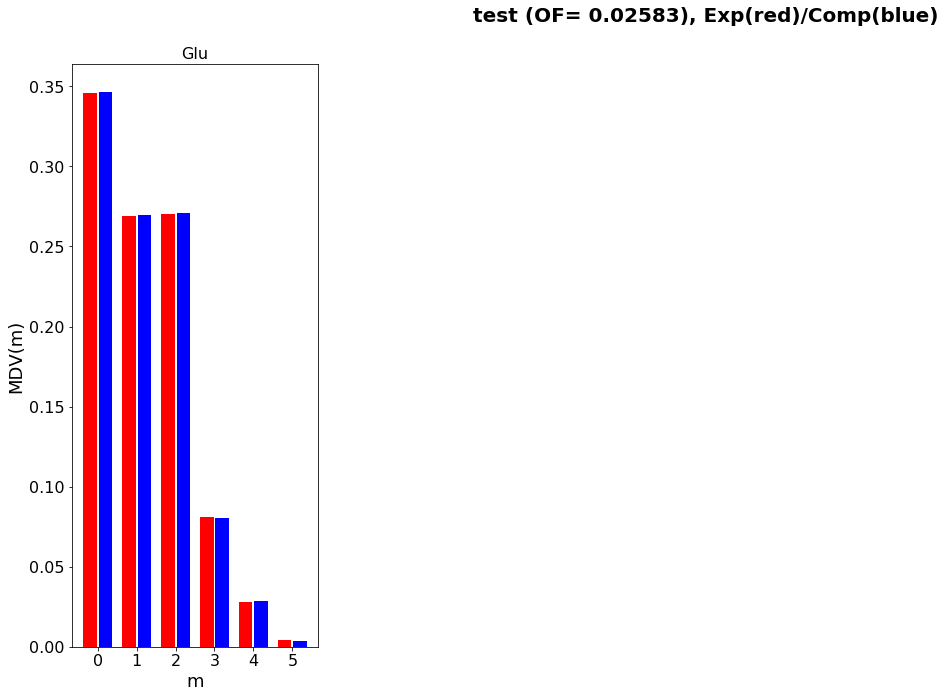

In [17]:
results.plotExpvsCompLabelFragment(titleFig='test')

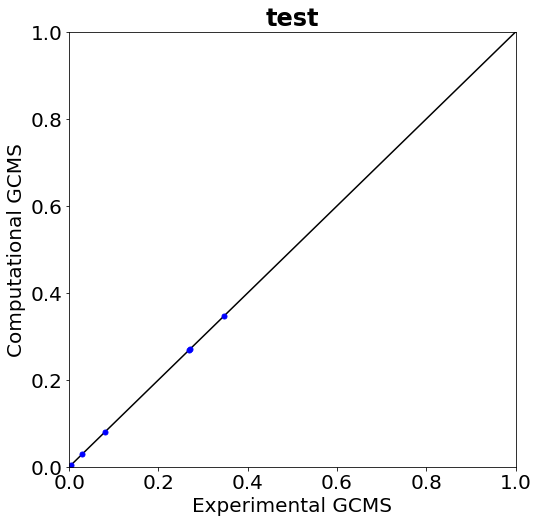

In [18]:
results.plotExpvsCompLabelXvsY(titleFig='test')

Results are stored in a reaction network where all ReactionNetworks methods are available:

In [19]:
results.reactionNetwork.reactionList.printFluxes(brief="False")

co2Out: 	150.0
r6: 	125.0
r1: 	100.0
r2: 	100.0
r7: 	75.0
r4: 	50.0
r5: 	50.0
r3: 	50.0
r8: 	50.0


In [20]:
results.EMUlabel['Glu']

array([ 0.34635,  0.26953,  0.27083,  0.08073,  0.02865,  0.00391])

In [21]:
results.fragDict['Glu'].mdv

array([ 0.346,  0.269,  0.27 ,  0.081,  0.028,  0.004])

A more detailed demonstration of these classes can be found in notebooks B2 and B3.

## TwoSC13Model, TSResults, TSFVAResults

These are the classes used for two-scale $^{13}$C Metabolic Flux Analysis (2S-$^{13}$C MFA).

Here, we offer a quick demonstration using the data from Toya *et al*. 2007. Notebook B4 offers a more complete demonstrating by regenerating all figures from Garcia Martin *et al*. 2015. Let's start by getting the input data from several files and blend them into a single sbml file:


In [22]:
datadir = os.environ['QUANTMODELPATH']+'/data/tests/Toya2010/2S/wt5h/'
strain ='wt5h'

BASEfilename      = datadir + 'EciJR904TKs_sbml2_fluxbounds-fixed-v1.xml'
FLUXESfilename    = datadir + 'FLUX'+strain+'.txt'
REACTIONSfilename = datadir + 'REACTIONS'+strain+'.txt'      
MSfilename        = datadir + 'GCMS'+strain+'.txt'
FEEDfilename      = datadir + 'FEED'+strain+'.txt'
MSSTDfilename     = datadir + 'GCMSerr'+strain+'.txt'

In [23]:
# Load initial SBML file
reacNet = ReactionNetworks.TSReactionNetwork(BASEfilename)
    
# Add Measured fluxes
reacNet.loadFluxBounds(FLUXESfilename)
# Add carbon transitions
reacNet.addTransitions(REACTIONSfilename)
# Add measured labeling information
reacNet.addLabeling(MSfilename,'LCMSLabelData',MSSTDfilename,minSTD=0.001)
# Add feed labeling information
reacNet.addFeed(FEEDfilename)

# Limit fluxes to 500       
reacNet.capFluxBounds(500)

# Creates sbml file to create the model. All files in the library can be represented by a file name or
#a tuple of the type: (fileName, string of contents)
SBMLfile = ('temp.xml',reacNet.write('toString'))

and then use the file to create the two-scale model:

In [24]:
TSmodel  = FM.TwoSC13Model(('temp.xml',reacNet.write('toString'))) 

We can then use the **findFluxesRanges** method to fit fluxes and find the ranges compatible with labeling data:

In [25]:
fluxNames = TSmodel.reactionNetwork.C13ReacNet.reactionList.getReactionNameList(level=1)
TSresult = TSmodel.findFluxesRanges(Nrep=300,fluxNames=fluxNames,procString='proc',limitFlux2Core=False) 

And see the fits with the **plotExpvsCompLabelFragment** method:

CPU times: user 3.04 s, sys: 5.41 s, total: 8.45 s
Wall time: 1.48 s


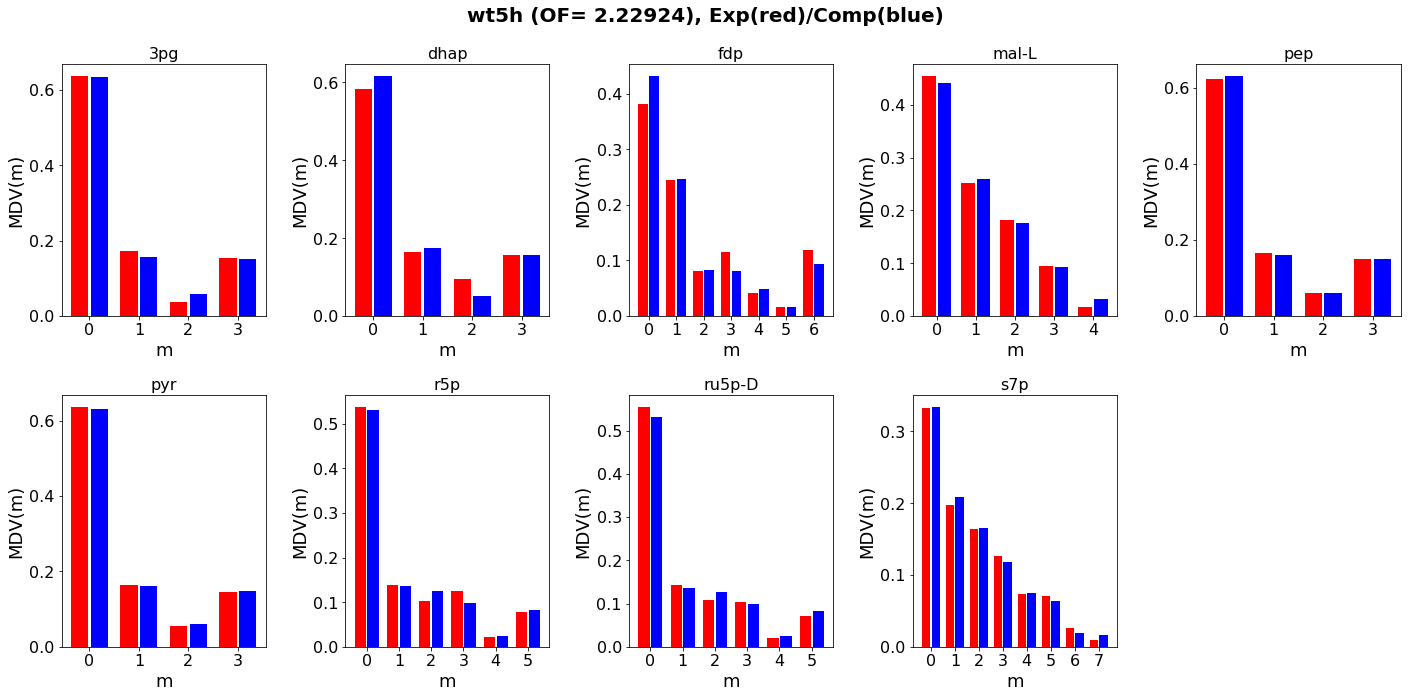

In [26]:
%%time
TSresult.plotExpvsCompLabelFragment(titleFig='wt5h')

In [27]:
TSresult.reactionNetwork.reactionList.printFluxes(brief="False")

ADK1: 	500.0
PROt4: 	500.0
INSt2r: 	-500.0
URAt2: 	500.0
GALUi: 	500.0
PROt2r: 	-500.0
INSt2: 	500.0
URAt2r: 	-500.0
NAt3_1: 	500.0
GALU: 	-499.983566
ADK3: 	-498.04825832
NDPK1: 	-489.017611657
ATPS4r: 	62.2266951712
CYTBO3: 	49.6028130477
NADH6: 	44.2418539704
H2Ot: 	-44.150162319
EX_h2o_e_: 	44.150162319
CO2t: 	-26.3222504087
EX_co2_e_: 	26.3222504087
O2t: 	24.8072165238
EX_o2_e_: 	-24.8072165238
PGK: 	-20.0388233079
GAPD: 	20.0388233079
PGM: 	-18.5921855979
ENO: 	18.5921855979
GLUDy: 	-15.4368074428
FUM: 	14.38912404
MDH: 	14.2710754477
PDH: 	13.0886275376
EX_h_e_: 	12.3727575207
EX_glc_e_: 	-11.7
GLCpts: 	11.7
ASPTA: 	-10.7797297328
THD2: 	10.6730350303
PPC: 	10.3874261012
FBA: 	9.82002047791
PFK: 	9.82002047791
TPI: 	9.68073327791
NH4t: 	8.93782429
EX_nh4_e_: 	-8.93782429
ADSS: 	8.62720939276
ADSL1r: 	8.62720939276
PGI: 	8.59401847372
INSK: 	8.38692522276
PUNP5: 	-8.38692522276
ADD: 	8.38692522276
NTD7: 	8.38111522276
PUNP1: 	8.38111522276
PPCK: 	7.67256568849
ATPM: 	7.6
ACONT: 	

MALt2_3: 	0.0
ACS: 	0.0
DKMPPD2: 	0.0
ME1: 	0.0
AACPS5: 	0.0
EX_maltttr_e_: 	0.0
DCYTD: 	0.0
GLUDC: 	0.0
CYANST: 	0.0
EX_hdca_e_: 	0.0
NTD9: 	0.0
AP5AH: 	0.0
AMANK: 	0.0
NO2t2r: 	0.0
DMATT: 	0.0
ASPt2_2: 	0.0
ASPt2_3: 	0.0
HYXNt: 	0.0
FUCt: 	0.0
MMM2: 	0.0
AB6PGH: 	0.0
MI1PP: 	0.0
PNTOt4: 	0.0
EX_acgam_e_: 	0.0
AMANAPE: 	0.0
DGSNt2: 	0.0
ACGAMT: 	0.0
THRAr: 	0.0
EX_asp_L_e_: 	0.0
PPPNDO: 	0.0
TMPPP: 	0.0
ADA: 	0.0
GALCTND: 	0.0
HISt2r: 	0.0
EDTXS4: 	0.0
GLUN: 	0.0
FBP: 	0.0
EDTXS3: 	0.0
TDPGDH: 	0.0
EX_na1_e_: 	0.0
SPMDAT2: 	0.0
DHCINDO: 	0.0
TTDCAt2: 	0.0
CINNDO: 	0.0
GLCDe: 	0.0
TMKr: 	0.0
CADVt: 	0.0
EX_malthx_e_: 	0.0
CPPPGO: 	0.0
D_LACt2: 	0.0
NNAM: 	0.0
PUNP3: 	0.0
EX_12ppd_S_e_: 	0.0
MANAO: 	0.0
HCINNMt2r: 	0.0
SUCBZS: 	0.0
HPYRRy: 	0.0
HPYRRx: 	0.0
GLUSy: 	0.0
IDOND: 	0.0
UDPGD: 	0.0
NADDP: 	0.0
EX_cytd_e_: 	0.0
SPODM: 	0.0
ALAabc: 	0.0
ABUTD: 	0.0
NTD8: 	0.0
EX_gbbtn_e_: 	0.0
NTD6: 	0.0
EX_galur_e_: 	0.0
DGK1: 	0.0
NTD2: 	0.0
NTD3: 	0.0
NTD1: 	0.0
TAGURr: 	0.0
EX_g6p_e_: 	0.0


In [28]:
resultELVA  = TSmodel.ELVA(TSresult,procString='proc')

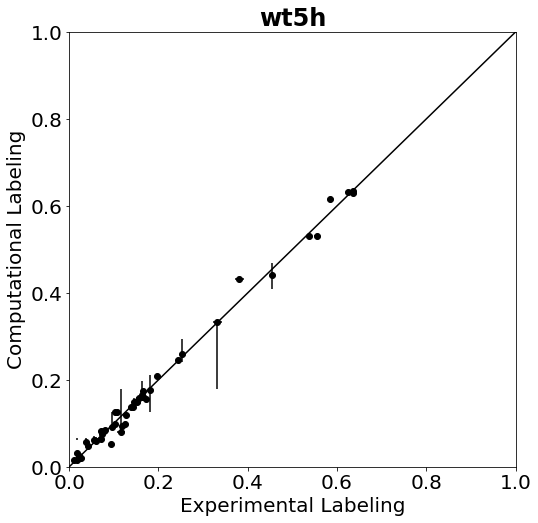

In [29]:
resultELVA.plotExpvsCompLabelxvsy(titleFig=strain,outputFileName="ELVAComparison-New.txt",save="ELVA-new.eps") 

In [34]:
dic = TSresult.reactionNetwork.reactionList.getReactionDictionary()

In [35]:
for i in dic:
    print str(dic[i]).split(':')[0],
    print 'lo',str(dic[i]).split('Net')[1].split('Exchange:')[0].split('[')[1].split(']')[0].split(':')[0]

CSND lo 0
G6PDH2r lo 2.78467
PMDPHT lo 0
TYRt2r lo 0
ASPt2 lo 0
CYNTt2 lo 0
PTA2 lo 0
AADDGT lo 0
GUAPRT lo 0
EX_glyc_e_ lo 0
NTD11 lo 0
EX_dmso_e_ lo 0
DAGK_EC lo 0
NACODA lo 0
GLYBabc lo 0
DHBSr lo 0
DDPA lo 0.34113
EX_uri_e_ lo 0
UAGPT3 lo 0
RBP4E lo 0
DHPS2 lo 0
LEUabc lo 0
2DGULRy lo 0
2DGULRx lo 0
GLUt2r lo 0
GLNabc lo 0
C181SN lo 0
OCTDPS lo 0
ARGORNt7 lo 0
KG6PDC lo 0
ATPM lo 0
EX_rmn_e_ lo 0
ADPT lo 0
EX_galct_D_e_ lo 0
EX_mnl_e_ lo 0
UNK3 lo 0
MALTTTRabc lo 0
TA1 lo -0.94063
G1PACT lo 0
KAS15 lo 0
ACALDt lo 0
CYSabc lo 0
NTD7 lo 0
TRE6PH lo 0
SHKK lo 0.34113
CO2t lo 0
G5SADs lo 0.1743
OMBZLM lo 0
ACALDi lo 0
TRE6PP lo 0
DMSOR1e lo 0
GLCRAL lo 0
EX_ac_e_ lo 0
NNDMBRT lo 0
OMPHHX lo 0
PANTS lo 0
DMQMT lo 0
AHC lo 0
HYD3 lo 0
E4PD lo 0
EX_glyald_e_ lo 0
GLTPD lo 0
Kt2r lo 0
EX_no3_e_ lo 0
PYNP2r lo 0
O2t lo 0
UGLT lo 0
EX_lys_L_e_ lo 0
ACLS lo 0.68895
GLYC3Pabc lo 0
AMMQT8_2 lo 0
NTPP7 lo 0
GLYCTO4 lo 0
NTPP5 lo 0
GALS3 lo 0
MANpts lo 0
ALLTNt2r lo 0
DHPPDA2 lo 0
ACODA lo 0.2680

RNDR1 lo 0
NDPK5 lo 0
GLYATi lo 0
EX_val_L_e_ lo 0
GLYCK lo 0
METS lo 0
KDOCT2 lo 0
SERAT lo 0
UAG2Ei lo 0
PROD2 lo 0
GLUR lo 0
MTAN lo 0
BiomassEcoli lo 0
FUMt2_2 lo 0
FUMt2_3 lo 0
EX_tre_e_ lo 0
PUNP6 lo 0
EX_arab_L_e_ lo 0
DMSOR2e lo 0
CHRPL lo 0
AGMHE lo 0
GSNK lo 0
NAt3_2 lo 0
EX_ura_e_ lo 0
PGMT lo 0
EX_mal_L_e_ lo 0
UREAt lo 0
EX_nmn_e_ lo 0
ALARi lo 0
GLYCDx lo 0
EX_indole_e_ lo 0
PYK lo 0
CRNt7 lo 0
RNDR3 lo 0
MALTpts lo 0
OCDCAt2 lo 0
NTD4 lo 0
AP4AH lo 0
ADMDCr lo 0
GLU5K lo 0.1743
EX_but_e_ lo 0
G6PDA lo 0
MDH lo 5.52252
EX_maltpt_e_ lo 0
DASYN_EC lo 0
EX_acmana_e_ lo 0
GLUCYS lo 0
PASYN_EC lo 0
ETHAAL lo 0
MLTG5 lo 0
LEUt2r lo 0
ACACCT lo 0
MLTG1 lo 0
XYLK lo 0
LPSSYN_EC lo 0
MLTG2 lo 0
U23GAAT lo 0
DKGLCNR1 lo 0
AMPN lo 0
NADH5 lo 0
NADH6 lo 0
DXYLK lo 0
NADH8 lo 0
NADH9 lo 0
3HCINNMH lo 0
GLYCTO2 lo 0
NAt3_15 lo 0
TMAOR2e lo 0
GAMpts lo 0
DHAPT lo 1e-05
GMAND lo 0
PTRCt2r lo 0
RBK lo 0
2DGLCNRx lo 0
2DGLCNRy lo 0
ADOCBLS lo 0
ADCS lo 0
OMCDC lo 0
AGPR lo -0.82202
SHK3Dr 

In [36]:
for i in dic:
    print str(dic[i]).split(':')[0],
    print 'hi',str(dic[i]).split('Net')[1].split('Exchange:')[0].split('[')[1].split(']')[0].split(':')[2]

CSND hi 0
G6PDH2r hi 3.21775
PMDPHT hi 0
TYRt2r hi 0
ASPt2 hi 0
CYNTt2 hi 0
PTA2 hi 0
AADDGT hi 0
GUAPRT hi 0
EX_glyc_e_ hi 0
NTD11 hi 0
EX_dmso_e_ hi 0
DAGK_EC hi 0
NACODA hi 0
GLYBabc hi 0
DHBSr hi 0
DDPA hi 0.72727
EX_uri_e_ hi 0
UAGPT3 hi 0
RBP4E hi 0
DHPS2 hi 0
LEUabc hi 0
2DGULRy hi 0
2DGULRx hi 0
GLUt2r hi 0
GLNabc hi 0
C181SN hi 0
OCTDPS hi 0
ARGORNt7 hi 0
KG6PDC hi 0
ATPM hi 0
EX_rmn_e_ hi 0
ADPT hi 0
EX_galct_D_e_ hi 0
EX_mnl_e_ hi 0
UNK3 hi 0
MALTTTRabc hi 0
TA1 hi -0.67262
G1PACT hi 0
KAS15 hi 0
ACALDt hi 0
CYSabc hi 0
NTD7 hi 0
TRE6PH hi 0
SHKK hi 0.72727
CO2t hi 0
G5SADs hi 0.76119
OMBZLM hi 0
ACALDi hi 0
TRE6PP hi 0
DMSOR1e hi 0
GLCRAL hi 0
EX_ac_e_ hi 0
NNDMBRT hi 0
OMPHHX hi 0
PANTS hi 0
DMQMT hi 0
AHC hi 0
HYD3 hi 0
E4PD hi 0
EX_glyald_e_ hi 0
GLTPD hi 0
Kt2r hi 0
EX_no3_e_ hi 0
PYNP2r hi 0
O2t hi 0
UGLT hi 0
EX_lys_L_e_ hi 0
ACLS hi 1.32374
GLYC3Pabc hi 0
AMMQT8_2 hi 0
NTPP7 hi 0
GLYCTO4 hi 0
NTPP5 hi 0
GALS3 hi 0
MANpts hi 0
ALLTNt2r hi 0
DHPPDA2 hi 0
ACODA hi 0.822

EX_xan_e_ hi 0
TMAOR1e hi 0
GLCP hi 0
DDPGALA hi 0
ACMANApts hi 0
AMAOTr hi 0
EX_thr_L_e_ hi 0
CS hi 6.45122
UGMDDS hi 0
PEPT_EC hi 0
NMNP hi 0
ACACt2 hi 0
PUNP5 hi 0
CITt7 hi 0
GALURt2r hi 0
PUNP1 hi 0
PUNP2 hi 0
AKGt2r hi 0
ASNN hi 0
TMPKr hi 0
C120SN hi 0
OHPHM hi 0
EX_pro_L_e_ hi 0
DADNt2 hi 0
EX_xyl_D_e_ hi 0
EX_gly_e_ hi 0
ASPO3 hi 0
ASPO4 hi 0
ASPO5 hi 0
ASPO6 hi 0
PPCSCT hi 0
FHL hi 0
PSSA_EC hi 0
XANt2 hi 0
HISTD hi 0
EX_k_e_ hi 0
CBMK hi 1.08593
DURIK1 hi 0
MALTHXabc hi 0
MDH3 hi 0
MDH2 hi 0
GND hi 3.21775
ACKr hi 0
EX_lac_L_e_ hi 0
DHORTS hi 0
NMNN hi 0
RNTR2 hi 0
PPC hi 17.00241
NTD10 hi 0
PPA hi 0
PRMICIi hi 0
RZ5PP hi 0
CSNt2 hi 0
NPHS hi 0
PPM hi 0
VALabc hi 0
PPS hi 0
NDPK1 hi 0
NTPP4 hi 0
EX_o2_e_ hi 0
GPDDA4 hi 0
DMSOR2 hi 0
DMSOR1 hi 0
PRAGSr hi 0.39666
GPDDA1 hi 0
GPDDA2 hi 0
GPDDA3 hi 0
NADTRHD hi 0
ADHEr hi 0
IPPMIb hi 0
SHCHCS2 hi 0
IPPS hi 0
SUCCabc hi 0
LPLIPA6 hi 0
CHLabc hi 0
ASAD hi -0.84378
DHPTDCs hi 0
XANt hi 0
EX_lcts_e_ hi 0
EX_orn_e_ hi 0
UACMAMO hi 0
